In [1]:
import pandas as pd
import numpy as np

# nlp pre-processing
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# nlp EDA
from wordcloud import WordCloud

#topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

#img load
from PIL import Image
import requests
from io import BytesIO
from fake_useragent import UserAgent 
from keras.preprocessing import image

# image plotting
import random
import matplotlib.pyplot as plt

In [10]:
import nltk
nltk.download('stopword')
# nltk.download('punkt')
# nltk.download('wordnet')

AttributeError: partially initialized module 'nltk' has no attribute 'data' (most likely due to a circular import)

In [ ]:
!pip uninstall nltk

## load dataframes

In [9]:
img_link_df = pd.read_pickle('attractions_img_links_df_anug.pkl')
att_loc_df = pd.read_pickle('attractions_loc_df_anug.pkl')

## Clean Data

In [10]:
img_link_df.shape

(52, 136)

In [52]:
display(img_link_df)

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
Wonderla Bengaluru,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Ragigudda Sri Prasanna Anjaneyaswamy Temple,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,...,None,None,None,None,None,None,None,None,None,None
ISKCON Temple Bangalore,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,None,None,None,None,None,None,None,None
Vidhana Soudha and Attara Kacheri,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Lalbagh Botanical Garden,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
UB City,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,...,None,None,None,None,None,None,None,None,None,None
Cubbon Park,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Bannerghatta National Park,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,https://dynamic-media-cdn.tripadvisor.com/medi...,...,None,None,None,None,None,None,None,None,None,None
Mahatma Gandhi (MG) Road,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Visvesvaraya Industrial and Technological Museum,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [11]:
att_loc_df.shape #different shape

(64, 4)

In [12]:
#try removing duplicates
att_loc_df.drop_duplicates(subset = 'name',inplace=True)
att_loc_df.shape

(52, 4)

### Clean Attraction names

In [13]:

def clean_name(name , stop):
    '''
    clean comment string, removing numbers, punctuation, non alphabetical words, replacing words,
    stop words, and changing to lowercase, 
    lemmatizing and stemming
        
    input: 
    comment = comment to be cleaned,
    stop = stopwords,
    replace = dictionary of words to replace
        
    output: cleaned string
    '''
    s = str(name.lower()) #lowercase
    
    s = re.sub(r'[^\w\s]', '', s) #remmove punctuation
    
    s_token = word_tokenize(s) #tokenize
        
    s_token = [w.strip() for w in s_token] #remove spaces
        
    s_token = [w for w in s_token if w not in stop] #remove stop words
    
    lemmatizer = WordNetLemmatizer() # Init Lemmatizer
    s_token_lemm = [lemmatizer.lemmatize(w) for w in s_token] #Lemmatize
        
    s_lemm = " ".join(s_token_lemm) #join back into one string
        
    return s_lemm

def display_topics(model, feature_names, no_top_words, topic_names):
    """
    display topics, a specified number of top words, and the topic number, if no names given
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def prob_df(X, topics):
    '''
    df of all documents as rows and the probablities of each topic as columns
        
    input: 
    X = model X components,
    topics = list of topic names,
        
    output: df 
    '''
    cols = topics

    df = pd.DataFrame(X.round(5), columns=cols)
    
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Check if there are any numeric columns
    if not numeric_df.empty:
        df['topic_choice'] = numeric_df.idxmax(axis=1)
        df['topic_value'] = numeric_df.max(axis=1)
    else:
        df['topic_choice'] = np.nan
        df['topic_value'] = np.nan

    return df

       
def view_att(att_index, df):
    '''
    plot 10 random images from an attraction given an attraction index
    '''
    ua = UserAgent()
    headers = {'user-agent': ua.random}
    
    #get all urls for an attraction
    att = df.loc[att_index,'name']
    url_list = list(df.loc[att_index])

    random_url_list = []
    
    # only allow up to 10 images to be shown at a time
    if len(url_list) > 10:
        random_url_list =  random.sample(url_list, 10) #choose 10 random urls
        
    img_list = [] 
    error = 0
    
    for url in random_url_list:

        try:
            #download img from url
            response = requests.get(url, headers = headers)
            image_io = BytesIO(response.content)
            img = image.load_img(image_io, target_size=(224, 224))
            img_list.append(img)
        except:
            error = error + 1
    
    plt.figure(figsize = (25,25));
    t = f"{att}, with index {att_index}"
    
    # plot 20 images and name of attraction and index as title
    plt.suptitle(t, fontsize=20)
    for index, i in enumerate(img_list):
        plt.subplot(10,10,index+1);

        img_a = np.array(i)
        plt.imshow(img_a)
        plt.axis('off')

Clean name and remove stop words for topic modeling

In [14]:
stop = stopwords.words('english')
stop += ['national', 'american']

attr_topics = att_loc_df.copy()
attr_topics['cleaned_name'] = attr_topics.apply (lambda x: clean_name(x['name'], stop), axis=1)
attr_topics.head()

,name,location,img_num,state,cleaned_name
0,Wonderla Bengaluru,Bengaluru,0,Bengaluru,wonderla bengaluru
1,Ragigudda Sri Prasanna Anjaneyaswamy Temple,Bengaluru,100,Bengaluru,ragigudda sri prasanna anjaneyaswamy temple
2,ISKCON Temple Bangalore,Bengaluru,0,Bengaluru,iskcon temple bangalore
3,Vidhana Soudha and Attara Kacheri,Bengaluru,127,Bengaluru,vidhana soudha attara kacheri
4,Lalbagh Botanical Garden,Bengaluru,0,Bengaluru,lalbagh botanical garden


### EDA

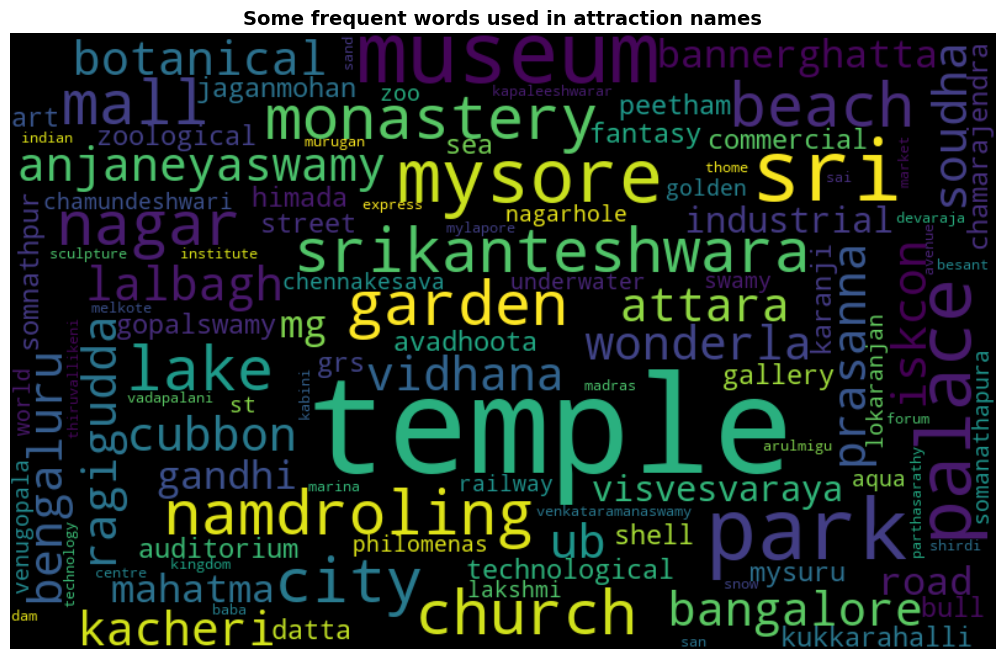

In [15]:
all_words = ' '.join([word for word in attr_topics['cleaned_name'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in attraction names", weight='bold', fontsize=14)
plt.show()

## Topic Modeling

In [16]:
names = list(attr_topics['cleaned_name'])

### Count Vectorization

In [17]:
cv = CountVectorizer(stop_words=stop, min_df = 1) 
X_cv = cv.fit_transform(names)
# pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())

#### Non-Negative Matrix Factorization (NMF) with Count Vectorization

In [18]:
topics = 12
topic_words = 10
topic_names = []

nmf_cv = NMF(topics)
X_nmf_cv = nmf_cv.fit_transform(X_cv)
display_topics(nmf_cv, cv.get_feature_names_out(), topic_words, topic_names)


Topic  0
temple, srikanteshwara, sai, thiruvallikeni, shirdi, baba, parthasarathy, arulmigu, venkataramanaswamy, vadapalani

Topic  1
museum, mysore, sand, sculpture, railway, technological, visvesvaraya, industrial, sea, shell

Topic  2
sri, garden, zoological, chamarajendra, prasanna, ragigudda, anjaneyaswamy, chamundeshwari, lalbagh, botanical

Topic  3
palace, gallery, art, auditorium, jaganmohan, mysuru, mysore, beach, nagar, besant

Topic  4
park, fantasy, grs, cubbon, nagarhole, bannerghatta, avadhoota, datta, peetham, lake

Topic  5
zoo, world, aqua, lokaranjan, underwater, beach, nagar, besant, marina, thiruvallikeni

Topic  6
mall, city, centre, forum, express, avenue, ub, datta, peetham, avadhoota

Topic  7
monastery, namdroling, golden, temple, lake, kukkarahalli, karanji, peetham, datta, avadhoota

Topic  8
kacheri, soudha, vidhana, attara, san, thome, church, gopalswamy, golden, garden

Topic  9
church, philomenas, st, san, thome, lake, karanji, kukkarahalli, avadhoota, 

#### Latent Dirichlet Allocation (LDA) with Count Vectorization

In [19]:
topics = 7
topic_words = 8
topic_names = []

lda_cv = LatentDirichletAllocation(topics)
X_lda_cv = lda_cv.fit_transform(X_cv)
display_topics(lda_cv, cv.get_feature_names_out(), topic_words, topic_names)


Topic  0
temple, garden, world, aqua, zoo, lokaranjan, underwater, mg

Topic  1
mysore, namdroling, monastery, palace, madras, indian, institute, technology

Topic  2
museum, mall, soudha, attara, kacheri, vidhana, avenue, express

Topic  3
temple, museum, church, technological, visvesvaraya, industrial, avadhoota, peetham

Topic  4
temple, beach, nagar, park, palace, art, gallery, auditorium

Topic  5
temple, sri, srikanteshwara, park, prasanna, ragigudda, anjaneyaswamy, baba

Topic  6
temple, city, lake, forum, centre, arulmigu, thiruvallikeni, parthasarathy


### TF-IDF Vectorization

In [20]:
tfid = TfidfVectorizer(stop_words= stop, min_df=3)
X_tfid = tfid.fit_transform(names)

#### Non-Negative Matrix Factorization (NMF) with TF-IDF Vectorization

In [21]:
topics = 11
topic_words = 6
topic_names = ['museums', 
               'entertainment',
               'beaches',
               'lakes',
              'gardens/zoo',
              'rivers',
              'museums',
              'landmarks',
              'art',
              'mountains',
              'seaside']

nmf_tfid = NMF(topics)
X_nmf_tfid = nmf_tfid.fit_transform(X_tfid)
display_topics(nmf_tfid, tfid.get_feature_names_out(), topic_words, topic_names)


Topic: ' museums '
temple, sri, park, palace, mysore, museum

Topic: ' entertainment '
park, temple, sri, palace, mysore, museum

Topic: ' beaches '
palace, mysore, temple, sri, park, museum

Topic: ' lakes '
sri, mysore, temple, park, palace, museum

Topic: ' gardens/zoo '
sri, temple, park, palace, mysore, museum

Topic: ' rivers '
mysore, museum, temple, sri, park, palace

Topic: ' museums '
temple, sri, park, palace, mysore, museum

Topic: ' landmarks '
park, temple, sri, palace, mysore, museum

Topic: ' art '
temple, sri, park, palace, mysore, museum

Topic: ' mountains '
mysore, temple, sri, park, palace, museum

Topic: ' seaside '
museum, temple, sri, park, palace, mysore


#### choose NMF with Count Vectorization

## Topic EDA & Cleaning

In [22]:
#get topic probablitity df
nmf_tfid_probs = prob_df(X_nmf_tfid, ['museums', 
               'entertainment',
               'beaches',
               'lakes',
              'gardens/zoo',
              'rivers',
              'museums',
              'landmarks',
              'art',
              'mountains',
              'seaside'])
nmf_tfid_probs.shape

(52, 13)

In [23]:
attr_topics['category'] = list(nmf_tfid_probs['topic_choice'])
attr_topics.drop(['cleaned_name', 'img_num'],axis= 1, inplace=True)
attr_topics.head()

,name,location,state,category
0,Wonderla Bengaluru,Bengaluru,Bengaluru,museums
1,Ragigudda Sri Prasanna Anjaneyaswamy Temple,Bengaluru,Bengaluru,museums
2,ISKCON Temple Bangalore,Bengaluru,Bengaluru,museums
3,Vidhana Soudha and Attara Kacheri,Bengaluru,Bengaluru,museums
4,Lalbagh Botanical Garden,Bengaluru,Bengaluru,museums


In [24]:
display(attr_topics)

,name,location,state,category
0,Wonderla Bengaluru,Bengaluru,Bengaluru,museums
1,Ragigudda Sri Prasanna Anjaneyaswamy Temple,Bengaluru,Bengaluru,museums
2,ISKCON Temple Bangalore,Bengaluru,Bengaluru,museums
3,Vidhana Soudha and Attara Kacheri,Bengaluru,Bengaluru,museums
4,Lalbagh Botanical Garden,Bengaluru,Bengaluru,museums
5,UB City,Bengaluru,Bengaluru,museums
6,Cubbon Park,Bengaluru,Bengaluru,landmarks
7,Bannerghatta National Park,Bengaluru,Bengaluru,landmarks
8,Mahatma Gandhi (MG) Road,Bengaluru,Bengaluru,museums
9,Visvesvaraya Industrial and Technological Museum,Bengaluru,Bengaluru,seaside


### Investigate Categories and manually change category or add location

Add sports, government, and science categories

In [31]:
category_words = {'Museum':'museums', 'Aquarium':'gardens/zoo', 'Stadium':'sports', 'Ampitheatre':'entertainment', 
                 'District':'entertainment','Historic House': 'landmarks', 'Pier': 'seaside', 'Theatre':'entertainment',
                 'Isle':'beaches','Glass':'art', 'Mall':'entertainment', 'Bend':'rivers', 'Gondola':'entertainment',
                 'Street':'entertainment', 'Habitat':'gardens/zoo', 'Whiskey':'entertainment',
                 'Distillery':'entertainment', 'Winery':'entertainment', 'Speedway':'sports',
                 'Orchards':'entertainment', 'Brewery':'entertainment', 'Mansion':'landmarks',
                 'Canyon':'parks', 'Speedway':'sports', 'Overlook':'parks', 'Science':'science',
                  'Natural History':'science', 'Home':'landmarks', 'Peak':'parks',
                 'Capitol':'government', 'Brewing':'entertainment', 'Library':'museums', 'Zoo':'gardens/zoo',
                 'Bourbon':'entertainment', 'Six Flags':'entertainment', 'Theme Park':'entertainment',
                  'Penitentiary':'landmarks', 'Historic Site':'landmarks',
                 'Water Park':'entertainment', 'Market Park':'entertainment', 'Historic District':'landmarks',
                 'Memorial':'landmarks', 'Space':'science',
                  'Lighthouse':'seaside',  'Birthplace':'landmarks',
                  'Spring':'rivers',
                 'Adventure':'entertainment', 'Botanical':'gardens/zoo', 'Sculpture':'art','Fair':'entertainment',
                 'Market':'entertainment', 'Fun':'entertainment', 'Plantation':'landmarks', 'Point':'parks',
                 'River':'rivers', 'Historic Park':'landmarks', 'Field':'sports', 'Explor':'museums', 
                  'Monument':'landmarks', 'Downtown':'entertainment', 'Forest':'parks', 'Tower':'landmarks',
                 'Canal':'rivers', 'Arch':'landmarks', 'Beach':'beaches', 'Island':'seaside', 'Casion':'entertainment',
                 'Distilling':'entertainment', 'Zoo':'gardens/zoo', 'Music Hall':'entertainment', 'Pier':'seaside',
                 'Art':'art',  'Tramway':'parks','Gondola':'parks', 'Caves':'parks',
                 'Battleship':'landmarks', 'USS':'landmarks', 'District':'entertainment', 'Chapel':'landmarks',
                 'Mount':'parks', 'Refuge':'parks', 'Church':'landmarks', 'University':'landmarks', 
                  'Cathedral':'landmarks', 'Water Park':'entertainment',}

for key,value in category_words.items():
    attr_topics['category'] = np.where(attr_topics['name'].str.contains(key), 
                                          value, attr_topics['category'])


In [32]:
# loc_changes = {138:'S Main St, Breckenridge, CO 80424', 937:'3600 S Las Vegas Blvd, Las Vegas, NV 89109',
#                1003:'6 W. Jackson St., Millersburg, OH 44654', 1047:None, 1117:'Benefit Street, Providence, RI',
#                1198:'MP 31, SD-87, Custer, SD 57730', 1420:'1330 Oglebay Dr, Wheeling, West Virgina 26003'}

In [33]:
# #chnage attraction categories
# for key,value in cat_changes.items():
#     attr_topics.loc[key]['category'] = value

# # add locations for some attractions
# for key,value in loc_changes.items():
#     attr_topics.loc[key]['location'] = value

#merge loc df with attractiion image links df
attr_topics_imgs = attr_topics.merge(img_link_df, left_on='name', right_index=True)

#group by attractions category
attr_topics_grouped = attr_topics_imgs.groupby('category')

### Investigate Each Category and plot 10 Random Images from Each Attraction in Category

4


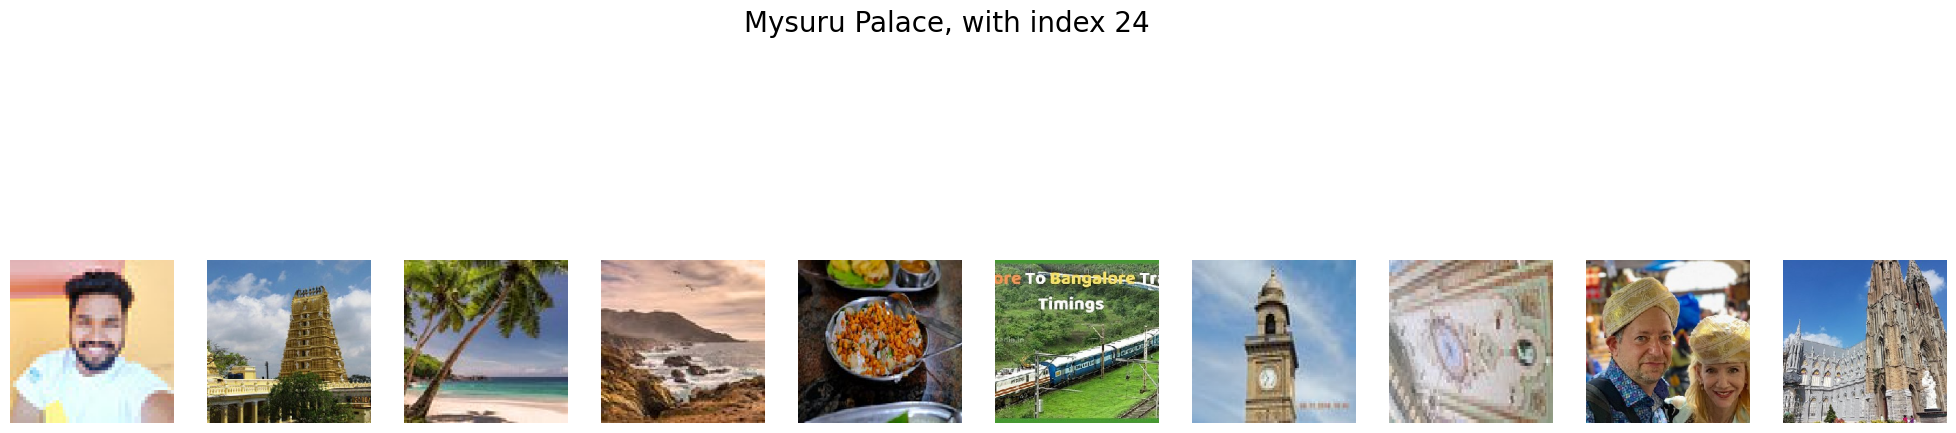

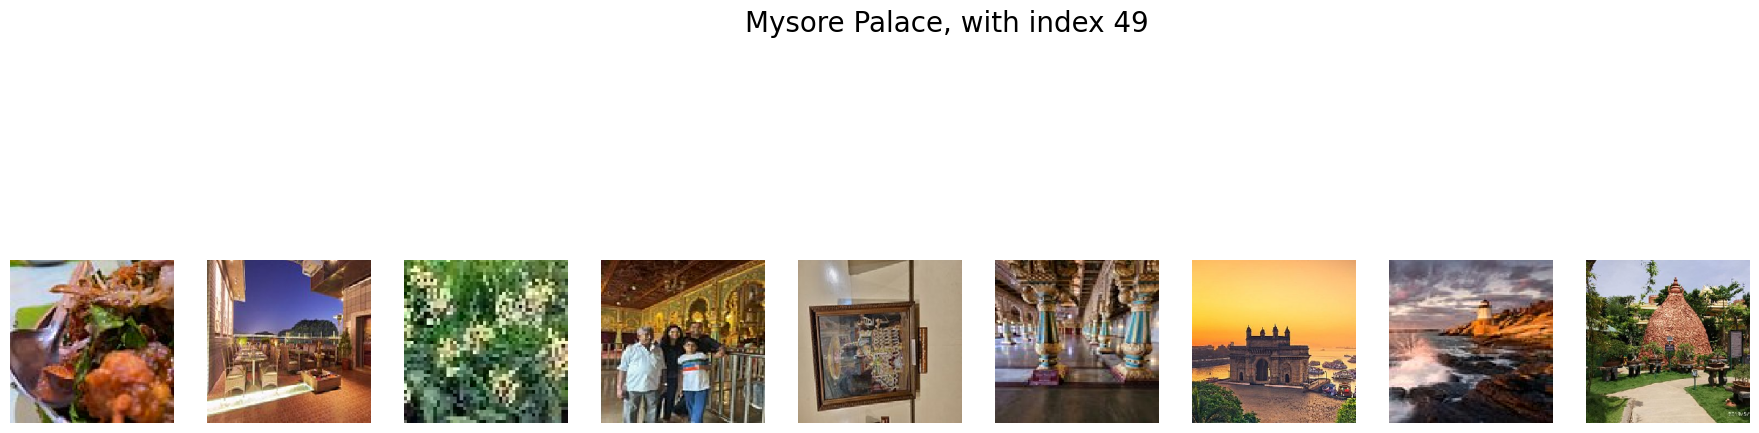

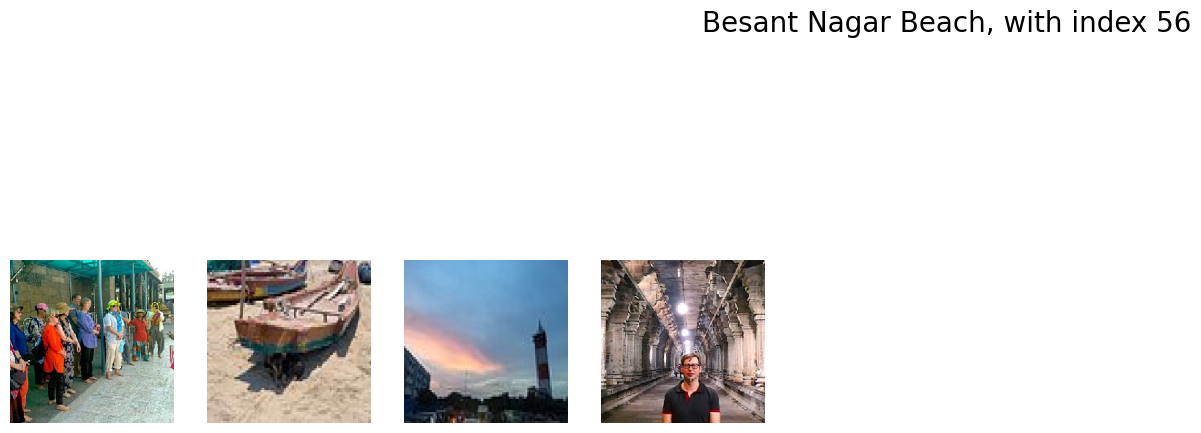

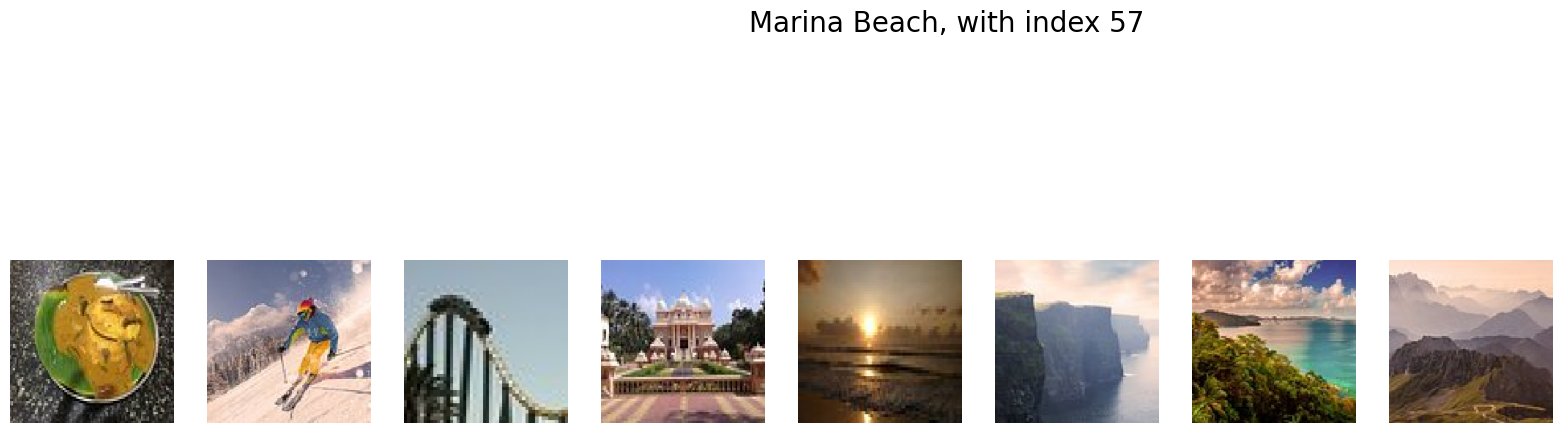

In [34]:
categories = ['museums', 'beaches','lakes', 'gardens/zoo', 'rivers', 'landmarks',  'art', 'entertainment',
              'seaside', 'sports', 'science']
# 'parks',

group = attr_topics_grouped.get_group(categories[1]) 
print(len(group))
for index, row in group.iterrows():
    view_att(index, attr_topics_imgs)

### New Data Frame for Attraction, Location, and Categorical Data for each Image

In [46]:
cols = ['name','location','category','url'] 
img_cat_df = pd.DataFrame(columns = cols)


end = len(attr_topics_imgs)
# for x in range(0, end ):
    
#     att = attr_topics_imgs.loc[x,'name']
#     loc = attr_topics_imgs.loc[x,'location']
#     cat = attr_topics_imgs.loc[x,'category']
    
#     #combine some categories
#     if cat == 'rivers' or cat == 'lakes' or cat == 'mountains':
#         cat = 'parks'
#     elif cat == 'government':
#         cat = 'landmarks'
#     elif cat == 'science':
#         cat = 'museums'
#     elif cat == 'seaside' or cat == 'beaches':
#         cat = 'beaches/ocean'
    
#     # #loop through all images and append data to df
#     url_list = attr_topics_imgs.iloc[x]
#     # for url in url_list[4:]:
#     #     row_df = pd.DataFrame([[att,loc,cat,url]], columns=cols)
#     #     img_cat_df = img_cat_df.append(row_df, ignore_index=True)

#     data = []
    
#     for url in url_list[4:]:
#         data.append([att, loc, cat, url])
#         row_df = pd.DataFrame(data, columns=cols)
#         img_cat_df = pd.concat([img_cat_df, row_df], ignore_index=True)


for idx, row in attr_topics_imgs.iterrows():
    att = row['name']
    loc = row['location']
    cat = row['category']

    # Combine some categories
    if cat == 'rivers' or cat == 'lakes' or cat == 'mountains':
        cat = 'parks'
    elif cat == 'government':
        cat = 'landmarks'
    elif cat == 'science':
        cat = 'museums'
    elif cat == 'seaside' or cat == 'beaches':
        cat = 'beaches/ocean'

    # Loop through all images and append data to df
    url_list = row[4:]
    data = []

    for url in url_list:
        data.append([att, loc, cat, url])

    row_df = pd.DataFrame(data, columns=cols)
    img_cat_df = pd.concat([img_cat_df, row_df], ignore_index=True)


In [54]:
img_cat_df

,name,location,category,url
0,Wonderla Bengaluru,Bengaluru,museums,None
1,Wonderla Bengaluru,Bengaluru,museums,None
2,Wonderla Bengaluru,Bengaluru,museums,None
3,Wonderla Bengaluru,Bengaluru,museums,None
4,Wonderla Bengaluru,Bengaluru,museums,None
...,...,...,...,...
7067,T Nagar,Chennai,museums,None
7068,T Nagar,Chennai,museums,None
7069,T Nagar,Chennai,museums,None
7070,T Nagar,Chennai,museums,None


In [48]:
img_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7072 entries, 0 to 7071
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      7072 non-null   object
 1   location  7072 non-null   object
 2   category  7072 non-null   object
 3   url       2791 non-null   object
dtypes: object(4)
memory usage: 221.1+ KB


### Pickle Data

In [55]:
img_cat_df.to_pickle('img_att_loc_topics_df.pkl', protocol=2)